CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 8 - Assignment
## Basic expectations
- \> = 70% accuracy
- < = 50000
- < = 20 epochs
- C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11 (cN is 1x1 Layer)
- 10 misclassified images display

## Version 1 - Batch Normalization
### Use Batch Normalization

### Results:
- Epochs: 20
- Parameters: 46,000
- Training Batch size: 64
- Testing Batch size: 64
- Training
  - Loss=0.6108
  - Batch_id=781
  - Accuracy=72.16%
- Testing
  - Average loss: 0.7305
  - Accuracy: 7451/10000 (74.51%)

### Analysis:
- Batch Normalization is working good and giving good results
- Maxpool, Dropout, Image augmentations and layers adjusted to get good results
- After 14th Epoch the network started to overfit though 20th Epoch was the best if we look at only training and testing accuracy


### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [4]:
# !pip install torchsummary

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import utils, model

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [6]:
SEED = 1

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

In [7]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.3, interpolation=3, fill=0, p=0.1),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### [4. Getting the CIFAR10 train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with *50000* records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [8]:
train = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 47924411.85it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [9]:
train_batch_size = 64
test_batch_size = 128

In [10]:
kwargs = {'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

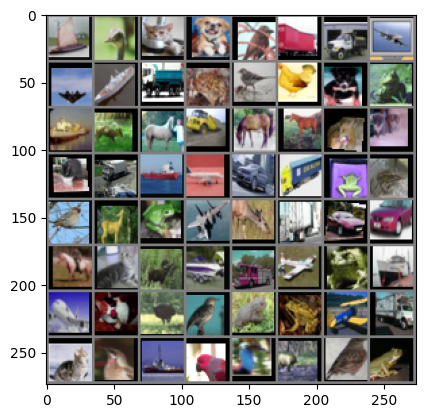

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog 


In [11]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(train_batch_size)))

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [13]:
dropout_value = 0.1
mymodel = model.Net8_Batch(dropout_value).to(device)
summary(mymodel, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 30, 30]           4,608
       BatchNorm2d-6           [-1, 32, 30, 30]              64
              ReLU-7           [-1, 32, 30, 30]               0
           Dropout-8           [-1, 32, 30, 30]               0
            Conv2d-9           [-1, 16, 30, 30]             512
           Conv2d-10           [-1, 16, 28, 28]           2,304
      BatchNorm2d-11           [-1, 16, 28, 28]              32
             ReLU-12           [-1, 16, 28, 28]               0
          Dropout-13           [-1, 16, 28, 28]               0
           Conv2d-14           [-1, 32,

In [14]:
optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, threshold_mode='rel', verbose=True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = utils.train(mymodel, device, train_loader, optimizer, criterion)
  test_acc, test_loss = utils.test(mymodel, device, test_loader, criterion)
  scheduler.step(test_loss)
  print("LR Rate:", optimizer.param_groups[0]['lr'], "\n")
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.0586 Batch_id=781 Accuracy=38.49: 100%|██████████| 782/782 [00:57<00:00, 13.60it/s]


Test set: Average loss: 1.4317, Accuracy: 4806/10000 (48.06%)

LR Rate: 0.01 

Epoch 2


Train: Loss=1.5602 Batch_id=781 Accuracy=51.97: 100%|██████████| 782/782 [00:54<00:00, 14.29it/s]


Test set: Average loss: 1.1900, Accuracy: 5722/10000 (57.22%)

LR Rate: 0.01 

Epoch 3


Train: Loss=1.1856 Batch_id=781 Accuracy=56.98: 100%|██████████| 782/782 [00:53<00:00, 14.58it/s]


Test set: Average loss: 1.2146, Accuracy: 5700/10000 (57.00%)

LR Rate: 0.01 

Epoch 4


Train: Loss=1.2867 Batch_id=781 Accuracy=60.20: 100%|██████████| 782/782 [00:53<00:00, 14.50it/s]


Test set: Average loss: 0.9717, Accuracy: 6510/10000 (65.10%)

LR Rate: 0.01 

Epoch 5


Train: Loss=1.3967 Batch_id=781 Accuracy=62.40: 100%|██████████| 782/782 [00:54<00:00, 14.25it/s]


Test set: Average loss: 0.9366, Accuracy: 6716/10000 (67.16%)

LR Rate: 0.01 

Epoch 6


Train: Loss=1.0122 Batch_id=781 Accuracy=63.90: 100%|██████████| 782/782 [00:53<00:00, 14.52it/s]


Test set: Average loss: 0.9317, Accuracy: 6675/10000 (66.75%)

LR Rate: 0.01 

Epoch 7


Train: Loss=1.2574 Batch_id=781 Accuracy=65.06: 100%|██████████| 782/782 [00:54<00:00, 14.27it/s]


Test set: Average loss: 0.8536, Accuracy: 6959/10000 (69.59%)

LR Rate: 0.01 

Epoch 8


Train: Loss=0.4870 Batch_id=781 Accuracy=66.22: 100%|██████████| 782/782 [00:56<00:00, 13.82it/s]


Test set: Average loss: 0.8318, Accuracy: 7079/10000 (70.79%)

LR Rate: 0.01 

Epoch 9


Train: Loss=0.7983 Batch_id=781 Accuracy=67.00: 100%|██████████| 782/782 [00:56<00:00, 13.92it/s]


Test set: Average loss: 0.8263, Accuracy: 7094/10000 (70.94%)

LR Rate: 0.01 

Epoch 10


Train: Loss=1.0885 Batch_id=781 Accuracy=67.76: 100%|██████████| 782/782 [00:54<00:00, 14.48it/s]


Test set: Average loss: 0.7966, Accuracy: 7236/10000 (72.36%)

LR Rate: 0.01 

Epoch 11


Train: Loss=1.0916 Batch_id=781 Accuracy=68.50: 100%|██████████| 782/782 [00:55<00:00, 14.18it/s]


Test set: Average loss: 0.7789, Accuracy: 7287/10000 (72.87%)

LR Rate: 0.01 

Epoch 12


Train: Loss=0.8471 Batch_id=781 Accuracy=69.02: 100%|██████████| 782/782 [00:53<00:00, 14.51it/s]


Test set: Average loss: 0.7456, Accuracy: 7363/10000 (73.63%)

LR Rate: 0.01 

Epoch 13


Train: Loss=1.5600 Batch_id=781 Accuracy=69.43: 100%|██████████| 782/782 [00:55<00:00, 14.03it/s]


Test set: Average loss: 0.7775, Accuracy: 7296/10000 (72.96%)

LR Rate: 0.01 

Epoch 14


Train: Loss=1.0419 Batch_id=781 Accuracy=69.41: 100%|██████████| 782/782 [00:54<00:00, 14.43it/s]


Test set: Average loss: 0.7539, Accuracy: 7359/10000 (73.59%)

LR Rate: 0.01 

Epoch 15


Train: Loss=0.8156 Batch_id=781 Accuracy=70.07: 100%|██████████| 782/782 [00:54<00:00, 14.42it/s]


Test set: Average loss: 0.7990, Accuracy: 7170/10000 (71.70%)

LR Rate: 0.001 

Epoch 16


Train: Loss=0.6491 Batch_id=781 Accuracy=72.13: 100%|██████████| 782/782 [00:54<00:00, 14.39it/s]


Test set: Average loss: 0.6792, Accuracy: 7625/10000 (76.25%)

LR Rate: 0.001 

Epoch 17


Train: Loss=0.5886 Batch_id=781 Accuracy=72.62: 100%|██████████| 782/782 [00:57<00:00, 13.59it/s]


Test set: Average loss: 0.6769, Accuracy: 7664/10000 (76.64%)

LR Rate: 0.001 

Epoch 18


Train: Loss=1.0297 Batch_id=781 Accuracy=72.89: 100%|██████████| 782/782 [00:54<00:00, 14.41it/s]


Test set: Average loss: 0.6769, Accuracy: 7620/10000 (76.20%)

LR Rate: 0.001 

Epoch 19


Train: Loss=0.9558 Batch_id=781 Accuracy=72.76: 100%|██████████| 782/782 [00:54<00:00, 14.22it/s]


Test set: Average loss: 0.6741, Accuracy: 7630/10000 (76.30%)

LR Rate: 0.001 

Epoch 20


Train: Loss=0.6334 Batch_id=781 Accuracy=72.91: 100%|██████████| 782/782 [00:54<00:00, 14.41it/s]


Test set: Average loss: 0.6724, Accuracy: 7643/10000 (76.43%)

LR Rate: 0.001 



CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

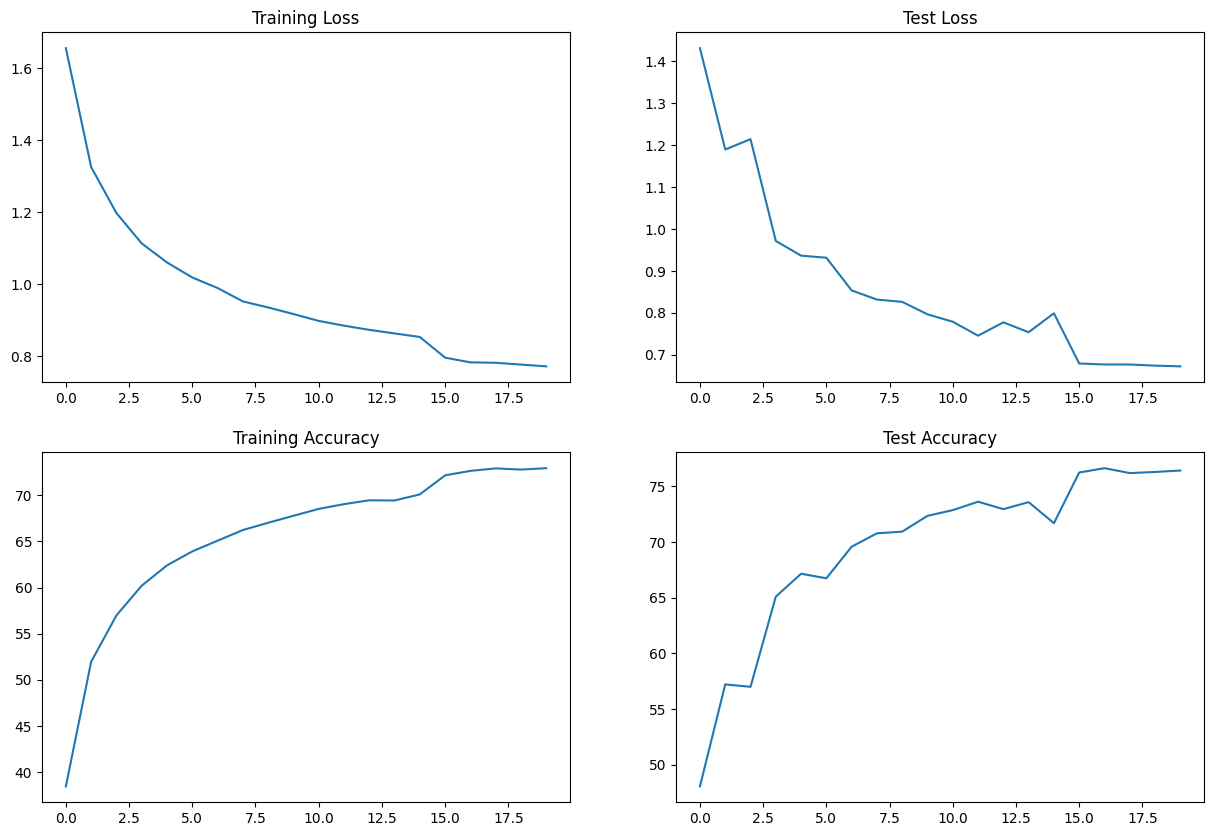

In [15]:
utils.drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

In [20]:
reqData = 10
images, nonMatchingLabels, incorrectPreds = utils.incorrectOutcomes(mymodel, device, test_loader, reqData)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


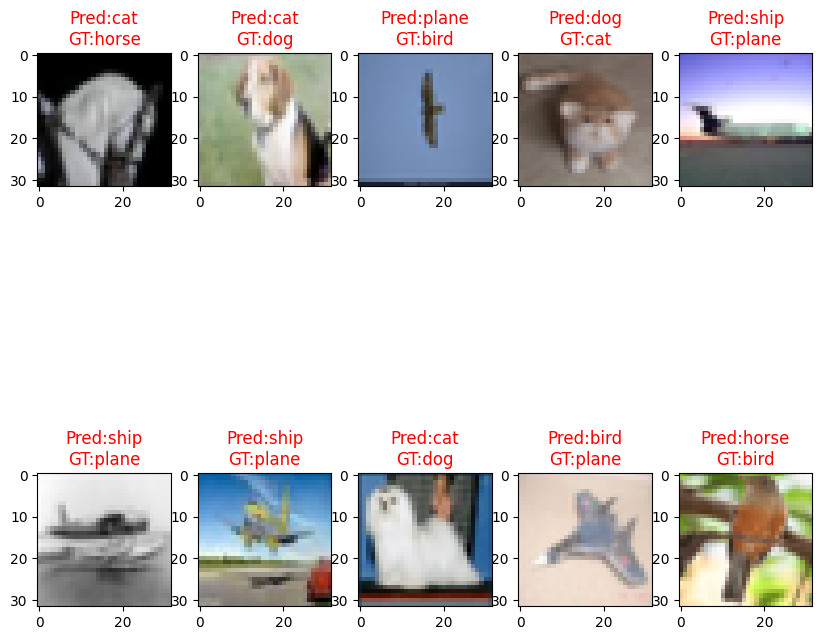

In [21]:
plt.figure(figsize=(10,10))
plt.tight_layout()

right = 0
mistake = 0

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

for i in range(reqData):
    image = images[i]
    pred = classes[incorrectPreds[i]]
    gt = classes[nonMatchingLabels[i]]

    plt.subplot(2,int(reqData/2),i+1)
    plt.imshow(imshow(image))
    plt.axis('on')

    # ret = model.predict(data, batch_size=1)
    #print(ret)

    plt.title("Pred:" + pred + "\nGT:" + gt, color='#ff0000', fontdict={'fontsize': 12})

plt.show()